Using reported Deaths to compare Covid-19 between countries
==

NB - this is very much a work-in-progress. I'm not an epidemiolgist. I've been munging data for many years. Comments/pull requests to the github repo are more than welcome (https://github.com/andrewl/covid-19)

The data comes from John Hopkins University (https://github.com/CSSEGISandData/COVID-19) and World Bank Open Dataset (https://data.worldbank.org)

There's been a lot of focus on charting and mapping reported cases of COVID-19. To my mind though this data seems too noisy - aside from the fact that there are many, many people for whom Coronavirus will be asymptomatic there is also no test for whether someone has _had_ Coronavirus and recovered. But the key problem with using reported cases is that of sampling. Comparing countries reported infection rates requires each country to be using the same sampling techniques, but we've seen a huge variety in the type of sampling
  
- Testing when people present at hospitals with symptoms
- Testing for people arriving at airports from certain destinations
- Random testing

Additionally the number of people tested (eg South Korea has tested nearly 1 in every 200 citizens), and the ratio of positive and negative tests are important variables that are overlooked when comparing infection rates.

Perhaps it's more appropriate (though not entirely without it's own difficulties) to look at the number of deaths - most nations have a formal notification processes for reporting deaths and the the cause of deaths. This seems to be a more consistent measure with which to compare countries than number of reported cases.

This work is done in a Jupyter notepad to show my working. To skip straight to the graphs, use one of the links below:


[Number of Deaths by date per country](#date)

[Number of Deaths per day after the first death per country](#day)

[Death rate per millions of population](#rate)


In [1]:
import warnings
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter('ignore')
sns.set(style="white", rc={"lines.linewidth": 3})
sns.set_palette("bright")

In [2]:
#Function to plot a graph
def plot_it(x_axis_title, y_axis_title,data):
  plt.figure(figsize=(16,10))
  g = sns.lineplot(x=x_axis_title, y=y_axis_title,
             hue="Country/Region",
             err_style=None,
             data=data)
  g.set_yscale("log")
       

Load the latest data on Covid-19 deaths from John Hopkins University

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")


Transform the data so that each row contains a measurement for each date for each country where there are more than 4 deaths.

In [4]:
a = df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], 
        var_name="date", 
        value_name="deaths-per-province")

#fix up some of the data
a = a.loc[a["Country/Region"] != "Cruise Ship"]

# for some countries the JHU data is broken down by sub-region (eg US state, CN province)
# aggregate these at the country level
a['date'] = a['date'].astype('datetime64[ns]')
a['co-date'] = a['Country/Region'] + "-" + a['date'].astype('str')
#a = a.loc[a["deaths-per-province"]>4]
a = a.join(a.groupby('co-date')['deaths-per-province'].sum(), on='co-date', rsuffix='-combined')
a.drop_duplicates(subset = "co-date", keep = 'first', inplace = True)

# tidy up the data
a.rename(columns={'deaths-per-province-combined': 'Deaths'}, inplace=True)
a = a[['Country/Region','date','Deaths']]

# normalise names to conform to world bank standards.
a["Country/Region"][a["Country/Region"]=="US"] = "United States"
a["Country/Region"][a["Country/Region"]=="Korea, South"]= "Korea, Rep."

a = a.loc[a["Deaths"]>5]

#display the final few records for sanity check
a.tail(5)

  

,Country/Region,date,Deaths
25157,Iran,2020-03-16,853
25158,"Korea, Rep.",2020-03-16,75
25159,France,2020-03-16,148
25202,United Kingdom,2020-03-16,56
25448,Netherlands,2020-03-16,24


<a id='blah'></a>

<a id="date"></a>

Number of Deaths per Country by Date
--

For countries with more than five reported deaths

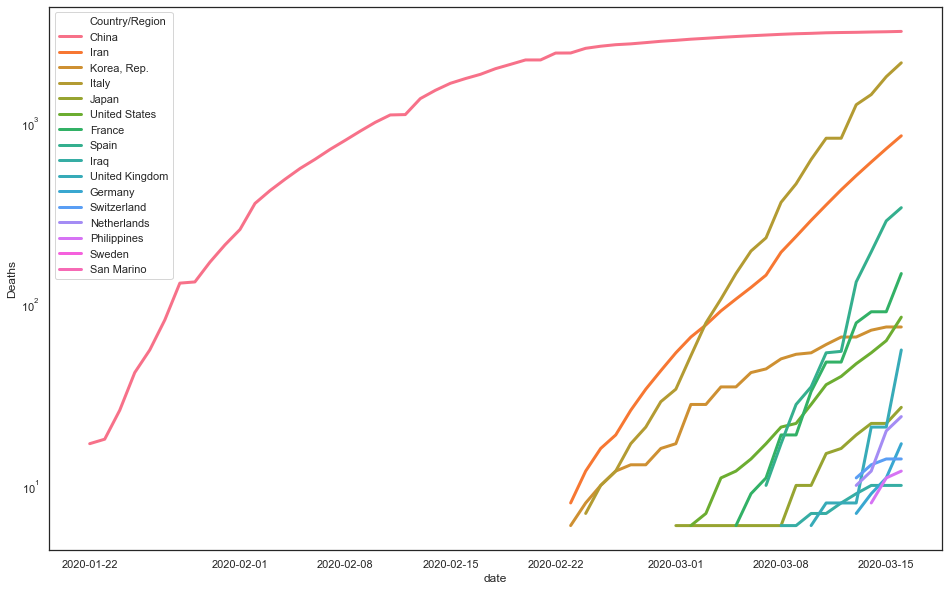

In [5]:
plot_it("date","Deaths",a)

In [6]:
#function to get the earliest date for a country (ie the first time > 4 deaths are registered)
def get_first_death_date (country):
  x = a[a['Country/Region'] == country]
  return x.sort_values(by='date', inplace=False).iloc[0,1]
  
a['first_death_date'] = a['Country/Region'].apply(get_first_death_date)
a['Days Since 5th Death'] = a['date'] - a['first_death_date']
a['Days Since 5th Death']= a['Days Since 5th Death'].astype(int) / 86400000000000

<a id='day'></a>
Deaths per Country by Day after 5th reported death
--

For countries with more than five reported deaths

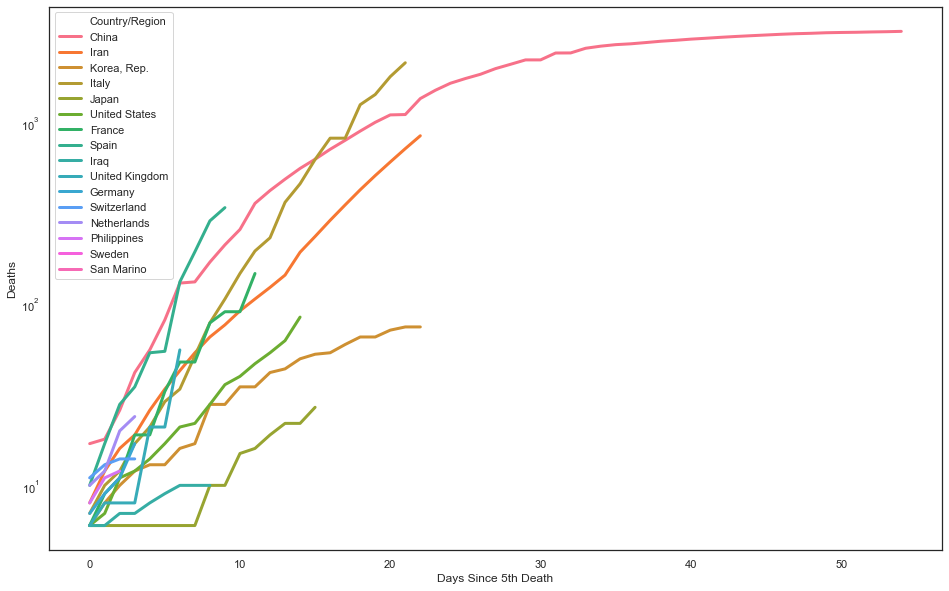

In [7]:
plot_it("Days Since 5th Death", "Deaths", a)

Absolute numbers are interesting, but let's try to factor in population data so we can get an idea of the death rate in each country.

In [8]:
#read in world population data from https://data.worldbank.org
demographics = pd.read_csv("data/API_SP.POP.TOTL_DS2_en_csv_v2_866861.csv", skiprows=4)

#merge the data into our death rate data set and calculate deaths per million population per day
demographics.rename(columns={'Country Name': 'Country/Region'}, inplace=True)
demographics = demographics[['Country/Region','2018']]
a = pd.merge(a, demographics, on='Country/Region')
a["Deaths Per Million Population"] = a["Deaths"]/(a["2018"]/1000000)

#sanity check the data
a.tail(5)

,Country/Region,date,Deaths,first_death_date,Days Since 5th Death,2018,Deaths Per Million Population
181,Philippines,2020-03-14,8,2020-03-14,0.0,106651922.0,0.075010
182,Philippines,2020-03-15,11,2020-03-14,1.0,106651922.0,0.103139
183,Philippines,2020-03-16,12,2020-03-14,2.0,106651922.0,0.112516
184,Sweden,2020-03-16,6,2020-03-16,0.0,10183175.0,0.589207
185,San Marino,2020-03-16,7,2020-03-16,0.0,33785.0,207.192541


<a id='rate'></a>
Deaths per million population by Day after 5th reported death
--



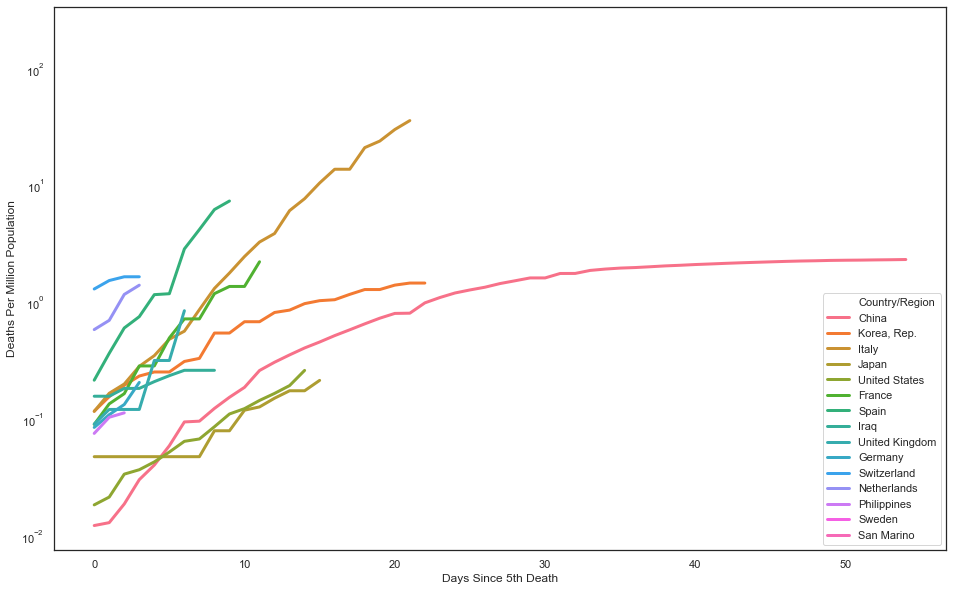

In [9]:
plot_it("Days Since 5th Death", "Deaths Per Million Population", a)